In [48]:
import pandas as pd
from scipy.stats import wilcoxon
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

pd.options.display.max_rows = 150

In [49]:
# Load ranked analysis with domains

ranked_df = pd.read_csv('./results/ranked_analysis_with_domains.csv', sep=',')
ranked_df

,result id,original,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15,search term,domain
0,S-EPMC6040727,1.5,1.333333,1.333333,1.2,0.000000,0.000000,1.333333,1.333333,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,AIDS,immunology
1,Mendeley_pzp26k9fy7,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,1.400000,1.400000,0.000000,0.0,0.0,0.000000,0.000000,AIDS,immunology
2,DRYAD_doi.org:10.5061:dryad.9r35r,0.0,0.000000,3.666667,11.0,22.000000,11.000000,0.000000,7.333333,22.0,22.000000,22.000000,2.444444,11.0,22.0,22.000000,22.000000,AIDS,immunology
3,veupathdb_DS_e8c4cf2187,0.0,0.000000,0.000000,0.0,2.200000,3.666667,0.000000,0.000000,0.0,1.833333,3.666667,0.000000,0.0,0.0,0.000000,1.100000,AIDS,immunology
4,Dataverse_10.5064_F6SF2T3N,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,1.857143,2.166667,0.000000,0.0,0.0,2.600000,4.333333,AIDS,immunology
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476,ZENODO_5044544,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,1.300000,1.625000,zika microcephaly,infectious disease
477,ZENODO_5008681,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.700000,zika microcephaly,infectious disease
478,S-EPMC6256666,1.7,1.700000,0.000000,0.0,0.000000,0.000000,1.700000,0.000000,0.0,0.000000,0.000000,1.700000,0.0,0.0,0.000000,0.000000,zika microcephaly,infectious disease
479,IMMPORT_SDY1515_2,0.0,0.000000,0.000000,0.0,6.333333,9.500000,0.000000,0.000000,0.0,3.800000,9.500000,0.000000,0.0,0.0,2.375000,3.800000,sublingual immunotherapy,allergy


In [50]:
combination_order = ['original', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6',
                     'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13',
                     'c14', 'c15']

In [51]:
def compute_scores(df, combination_order):
    final_df = pd.DataFrame()

    for combi in combination_order:
        df_comb = df[['search term', combi]].copy()
        df_comb_sum = df_comb.groupby('search term').sum().reset_index()
        if final_df.empty:
            final_df = df_comb_sum
        else: 
            final_df = final_df.merge(df_comb_sum, on = 'search term')

    final_df.columns = ['search term'] + combination_order
    return final_df

In [52]:
def perform_wilcoxon_test(data):
    data = data.drop('search term', axis = 1)
    # Get the column names
    columns = data.columns
    
    # Initialize a list to hold the results
    results = []
    
    # Perform the Wilcoxon signed-rank test for each pair of columns
    for i in range(len(columns)):
        for j in range(i + 1, len(columns)):
            col1 = columns[i]
            col2 = columns[j]
            if (data[col1].equals(data[col2])):
                stat = np.NaN
                p = np.NaN
                results.append((col1, col2, stat, p))
            else:
                stat, p = wilcoxon(data[col1], data[col2])
                results.append((col1, col2, stat, p))
            
            
    # Create a DataFrame from the results
    results_df = pd.DataFrame(results, columns=['set 1', 'set 2', 'statistic', 'p-value'])
    return results_df

In [53]:
def compare_scores(scores, columns):
    score_comparisons = {}
    for i in range(len(columns)):
        for j in range(i + 1, len(columns)):
            set1 = columns[i]
            set2 = columns[j]
            if scores[set1] > scores[set2]:
                score_comparisons[(set1, set2)] = set1
            else:
                if scores[set1] < scores[set2]:
                    score_comparisons[(set1, set2)] = set2
                else:
                    score_comparisons[(set1, set2)] = "tie"
    return score_comparisons

In [54]:
def add_winner(row):
    set1, set2 = row['set 1'], row['set 2']
    return winners[(set1, set2)]

In [55]:
def swap_sets(row):
    s1_index = combination_order.index(row['set 1'])
    s2_index = combination_order.index(row['set 2'])
    if s2_index < s1_index:
        return pd.Series([row['set 1'], row['set 2'], row['p-value']])  
    else:
        return pd.Series([row['set 2'], row['set 1'], row['p-value']])

In [56]:
def create_heatmap_with_winners(df, title, filename):
    heatmap_data = df.pivot('set 1', 'set 2', 'p-value')

    # Reorder index and columns
    heatmap_data = heatmap_data.reindex(combination_order, axis = 0)
    heatmap_data = heatmap_data.reindex(combination_order, axis = 1)

    # Combine winner and p-value in the annotation
    formatted_text = np.empty(heatmap_data.shape, dtype = object)
    
    for i in range(len(combination_order)):
        for j in range(len(combination_order)):
            if not np.isnan(heatmap_data.iloc[i, j]):
                formatted_text[i, j] = "{}\n{:.3f}".format(df[(df['set 1'] == combination_order[i]) & (df['set 2'] == combination_order[j])]['winner'].values[0], df[(df['set 1'] == combination_order[i]) & (df['set 2'] == combination_order[j])]['p-value'].values[0])
        else:
            formatted_text[i, j] = ""

    # Create heatmap using seaborn
    sns.set(font_scale = 1.4)
    sns.set_style('white')
    plt.figure(figsize = (24, 12))
    sns.heatmap(heatmap_data, cmap='BuPu_r', annot=formatted_text, fmt="", cbar_kws={'label': 'p-values'})
    plt.savefig(f'../alternate_test/results/{filename}.png', dpi = 150, bbox_inches = 'tight')
    plt.show()

In [57]:
exp_techniques_ranked_df = ranked_df.loc[ranked_df['domain'] == 'experimental techniques']
exp_techniques_ranked_df

,result id,original,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15,search term,domain
145,PRJEB24673,3.200000,3.200000,1.777778,0.000000,0.000000,0.000000,3.200000,1.777778,0.000000,0.000000,0.000000,3.200000,2.000000,0.000000,0.000000,0.000000,gwas,experimental techniques
146,DRYAD_doi.org:10.5061:dryad.612jm644q,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.700000,0.000000,0.000000,0.000000,0.000000,0.000000,gwas,experimental techniques
147,Mendeley_xwzp5ymp24,0.000000,0.000000,0.000000,4.250000,5.666667,8.500000,0.000000,0.000000,2.428571,5.666667,5.666667,0.000000,0.000000,2.833333,3.400000,5.666667,gwas,experimental techniques
148,EGAS00001000917,4.250000,4.250000,2.125000,0.000000,0.000000,0.000000,4.250000,2.125000,0.000000,0.000000,0.000000,4.250000,2.428571,0.000000,0.000000,0.000000,gwas,experimental techniques
149,Mendeley_2zdd47c94h,0.000000,0.000000,0.000000,0.000000,1.888889,2.428571,0.000000,0.000000,0.000000,1.888889,2.833333,0.000000,0.000000,0.000000,0.000000,1.888889,gwas,experimental techniques
150,ZENODO_3383130,0.000000,2.375000,3.800000,3.166667,3.800000,2.111111,2.375000,3.800000,4.750000,3.800000,2.375000,2.375000,4.750000,4.750000,4.750000,3.166667,gwas,experimental techniques
151,ZENODO_3383141,0.000000,2.714286,4.750000,3.800000,4.750000,2.375000,2.714286,6.333333,6.333333,4.750000,2.714286,2.714286,6.333333,6.333333,6.333333,3.800000,gwas,experimental techniques
152,ZENODO_1067750,0.000000,2.222222,3.333333,2.857143,3.333333,0.000000,2.222222,3.333333,3.333333,3.333333,2.222222,2.222222,4.000000,4.000000,3.333333,2.857143,gwas,experimental techniques
153,ZENODO_4289137,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.111111,1.900000,0.000000,gwas,experimental techniques
154,EGAD00010001463,8.500000,8.500000,8.500000,5.666667,1.700000,0.000000,8.500000,8.500000,3.400000,1.700000,0.000000,8.500000,8.500000,2.428571,0.000000,0.000000,gwas,experimental techniques


In [58]:
# Calculate scores per search term per combination

exp_techniques_scores_df = compute_scores(exp_techniques_ranked_df, combination_order)
exp_techniques_scores_df

,search term,original,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15
0,gwas,45.092857,51.761508,53.381349,53.393254,54.853175,54.498016,51.761508,53.298016,53.998016,54.799603,54.311508,51.761508,53.067460,54.056349,54.155159,54.354365
1,metabolomics,46.971429,50.876984,50.876984,50.988095,50.112302,48.599603,50.876984,50.876984,51.335317,51.434524,48.673810,50.876984,50.876984,50.779762,50.329762,51.098413
2,tuberculin skin test,55.576984,57.576984,58.076984,57.835317,57.826984,58.251984,57.576984,58.112698,58.019841,58.110317,58.076984,57.612698,57.865079,58.165079,57.965873,57.076984


In [59]:
# Run Wilcoxon test

exp_techniques_wilcoxon_df = perform_wilcoxon_test(exp_techniques_scores_df)
exp_techniques_wilcoxon_df

/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:2981: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


,set 1,set 2,statistic,p-value
0,original,c1,0.0,0.250000
1,original,c2,0.0,0.250000
2,original,c3,0.0,0.250000
3,original,c4,0.0,0.250000
4,original,c5,0.0,0.250000
5,original,c6,0.0,0.250000
6,original,c7,0.0,0.250000
7,original,c8,0.0,0.250000
8,original,c9,0.0,0.250000
9,original,c10,0.0,0.250000


In [60]:
# Export scores per search term

exp_techniques_scores_df.to_csv('../alternate_test/results/scores_exp_techniques.csv', index = False)

In [61]:
# Drop search term column

exp_techniques_scores_only_df = exp_techniques_scores_df.drop(columns = ['search term'])
exp_techniques_scores_only_df

,original,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15
0,45.092857,51.761508,53.381349,53.393254,54.853175,54.498016,51.761508,53.298016,53.998016,54.799603,54.311508,51.761508,53.067460,54.056349,54.155159,54.354365
1,46.971429,50.876984,50.876984,50.988095,50.112302,48.599603,50.876984,50.876984,51.335317,51.434524,48.673810,50.876984,50.876984,50.779762,50.329762,51.098413
2,55.576984,57.576984,58.076984,57.835317,57.826984,58.251984,57.576984,58.112698,58.019841,58.110317,58.076984,57.612698,57.865079,58.165079,57.965873,57.076984


In [62]:
# Compute total scores per combination

exp_techniques_total_scores_df = exp_techniques_scores_only_df.sum()
exp_techniques_total_scores_df

original    147.641270
c1          160.215476
c2          162.335317
c3          162.216667
c4          162.792460
c5          161.349603
c6          160.215476
c7          162.287698
c8          163.353175
c9          164.344444
c10         161.062302
c11         160.251190
c12         161.809524
c13         163.001190
c14         162.450794
c15         162.529762
dtype: float64

In [63]:
# Determine winners by comparing combination scores

winners = compare_scores(exp_techniques_total_scores_df, combination_order)
winners

{('original', 'c1'): 'c1',
 ('original', 'c2'): 'c2',
 ('original', 'c3'): 'c3',
 ('original', 'c4'): 'c4',
 ('original', 'c5'): 'c5',
 ('original', 'c6'): 'c6',
 ('original', 'c7'): 'c7',
 ('original', 'c8'): 'c8',
 ('original', 'c9'): 'c9',
 ('original', 'c10'): 'c10',
 ('original', 'c11'): 'c11',
 ('original', 'c12'): 'c12',
 ('original', 'c13'): 'c13',
 ('original', 'c14'): 'c14',
 ('original', 'c15'): 'c15',
 ('c1', 'c2'): 'c2',
 ('c1', 'c3'): 'c3',
 ('c1', 'c4'): 'c4',
 ('c1', 'c5'): 'c5',
 ('c1', 'c6'): 'tie',
 ('c1', 'c7'): 'c7',
 ('c1', 'c8'): 'c8',
 ('c1', 'c9'): 'c9',
 ('c1', 'c10'): 'c10',
 ('c1', 'c11'): 'c11',
 ('c1', 'c12'): 'c12',
 ('c1', 'c13'): 'c13',
 ('c1', 'c14'): 'c14',
 ('c1', 'c15'): 'c15',
 ('c2', 'c3'): 'c2',
 ('c2', 'c4'): 'c4',
 ('c2', 'c5'): 'c2',
 ('c2', 'c6'): 'c2',
 ('c2', 'c7'): 'c2',
 ('c2', 'c8'): 'c8',
 ('c2', 'c9'): 'c9',
 ('c2', 'c10'): 'c2',
 ('c2', 'c11'): 'c2',
 ('c2', 'c12'): 'c2',
 ('c2', 'c13'): 'c13',
 ('c2', 'c14'): 'c14',
 ('c2', 'c15'): '

In [64]:
# Add winners to Wilcoxon test results

exp_techniques_wilcoxon_df['winner'] = exp_techniques_wilcoxon_df.apply(add_winner, axis = 1)
exp_techniques_wilcoxon_df

,set 1,set 2,statistic,p-value,winner
0,original,c1,0.0,0.250000,c1
1,original,c2,0.0,0.250000,c2
2,original,c3,0.0,0.250000,c3
3,original,c4,0.0,0.250000,c4
4,original,c5,0.0,0.250000,c5
5,original,c6,0.0,0.250000,c6
6,original,c7,0.0,0.250000,c7
7,original,c8,0.0,0.250000,c8
8,original,c9,0.0,0.250000,c9
9,original,c10,0.0,0.250000,c10


In [65]:
exp_techniques_wilcoxon_df['winner'].value_counts()

c9     15
c8     14
c13    13
c4     12
c15    11
c14    10
c2      9
c7      8
c3      7
c12     6
c5      5
c10     4
c11     3
c1      1
c6      1
tie     1
Name: winner, dtype: int64

In [66]:
exp_techniques_wilcoxon_df[exp_techniques_wilcoxon_df['p-value'] <= 0.05]

,set 1,set 2,statistic,p-value,winner


In [67]:
# Export Wilcoxon test results

exp_techniques_wilcoxon_df.to_csv('../alternate_test/results/wilcoxon_with_winners_exp_techniques.csv', index = False)

In [68]:
# Rearrange rows so that heatmap cells are rendered below the main diagonal

exp_techniques_wilcoxon_df[['set 1', 'set 2', 'p-value']] = exp_techniques_wilcoxon_df.apply(swap_sets, axis = 1)

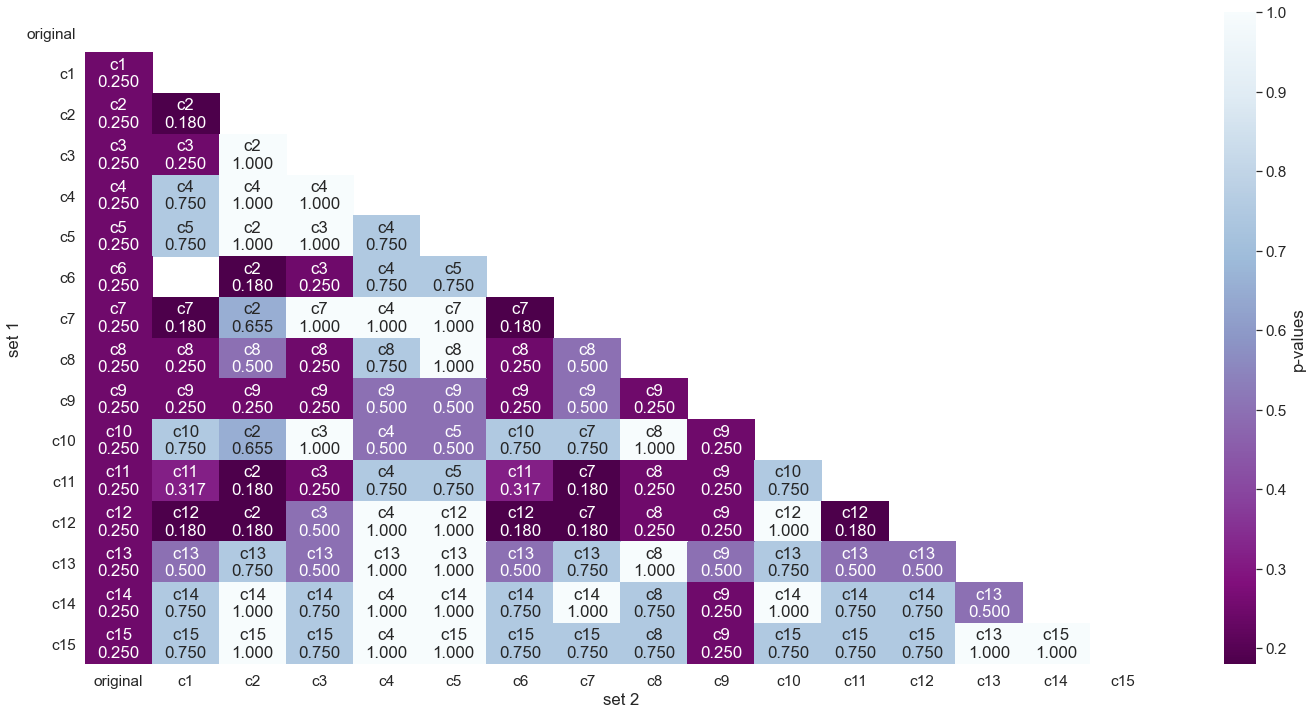

In [69]:
# Generate heatmap of p-values with winners

create_heatmap_with_winners(exp_techniques_wilcoxon_df, 'Heatmap of p-values | Wilcoxon test', 
                            'wilcoxon_heatmap_with_winners_exp_techniques')